In [1]:
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import gzip
import pickle
import numpy as np
from sympl import get_constant

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

/home/data/miniconda3/lib/python3.8/site-packages/sympl/_core/dataarray.py:6: FutureWarning: xarray subclass DataArray should explicitly define __slots__
  class DataArray(xr.DataArray):


In [2]:
# %matplotlib notebook
from sympl import get_constant
from scipy import interpolate

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

Lv=2260000

lat1=11
lat2=17
lon1=35
lon2=41

common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000

def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

with gzip.open('/home/scratch/Abel_data/advection_meanv4', 'rb') as f:
    DSExmean, DSEymean, DSEzmean, windxmean, windymean, windzmean= pickle.load(f)

convergenceh=[]
convergenceh1=[]
convergenceh2=[]
convergencev=[]
CONVh=[]
CONVh1=[]
CONVh2=[]
CONVv=[]
windx=[]
windy=[]
windz=[]
DSEx=[]
DSEy=[]
DSEz=[]

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'rb') as f:
    heat_index= pickle.load(f)

test=0

for e in heat_index:
    
#     if test==100:
#         break
        
    test=test+1
    
    print(test)

    i=e[0]
    j=int(e[1])
    t_list=e[2]
    ignore=0

    for t in t_list:
        
#         t=t_0+k
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
        temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

        if np.min(press.values[0])<97000:
            ignore=1
            print(np.min(press.values[0]))
            continue

        uwind=interpol1d(uwind, press)
        nwind=interpol1d(nwind, press)
        temp=interpol1d(temp, press)

        rho=(p_std[:,np.newaxis,np.newaxis]/(Rd*temp))[:,1:-1,1:-1]

        press_int=np.insert(p_std, 0, 101300)       

        # dz calculation

        dp=(press_int[:-1]-press_int[1:])

        dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
        z=dz.cumsum(axis=0)

        dse=Cp*temp+g*z

        dudx=(uwind[:,1:-1,2:]-uwind[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
        dvdy=(nwind[:,2:,1:-1]*np.cos(lat_rad[2:,1:-1])-nwind[:,:-2,1:-1]*np.cos(lat_rad[:-2,1:-1]))/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))

        dwdp=-(dudx+dvdy)
        w=np.cumsum(dwdp*-dp[:,np.newaxis,np.newaxis],axis=0)

#         dDdx=(dse[:,1:-1,2:]*uwind[:,1:-1,2:]-dse[:,1:-1,:-2]*uwind[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
#         dDdy=(dse[:,2:,1:-1]*nwind[:,2:,1:-1]*np.cos(lat_rad[2:,1:-1])-dse[:,:-2,1:-1]*nwind[:,:-2,1:-1]*np.cos(lat_rad[:-2,1:-1]))/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
        
        windx.append(uwind[:,1:-1,1:-1])
        DSEx.append((dse[:,1:-1,2:]-dse[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1])))
        windy.append(nwind[:,1:-1,1:-1])
        DSEy.append((dse[:,2:,1:-1]-dse[:,:-2,1:-1])/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000))
#         dDdx=uwind[:,1:-1,1:-1]*(dse[:,1:-1,2:]-dse[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
#         dDdy=nwind[:,1:-1,1:-1]*(dse[:,2:,1:-1]-dse[:,:-2,1:-1])/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000)

        
        windz.append(w)
        dsez=uwind[:,1:-1,1:-1].copy()
        dsez[1:]=(dse[1:,1:-1,1:-1]-dse[:-1,1:-1,1:-1])/(-dp[1:,np.newaxis,np.newaxis])
        dsez[0]=(dse[1,1:-1,1:-1]-dse[0,1:-1,1:-1])/(-dp[1])
        DSEz.append(dsez)
#         dDdp=dDdx.copy()
#         dDdp[1:]=w[1:,:,:]*(dse[1:,1:-1,1:-1]-dse[:-1,1:-1,1:-1])/(dp[1:,np.newaxis,np.newaxis])
#         dDdp[0]=w[0]*(dse[1,1:-1,1:-1]-dse[0,1:-1,1:-1])/(dp[1])

#         conv_flux=-(dDdx+dDdy+dDdp)
#         conv=((conv_flux*dp[:,np.newaxis,np.newaxis])/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly)[:].sum(axis=(1,2))*86400
        
#         conv_flux=-(dDdx+dDdy)
#         convh=((conv_flux*dp[:,np.newaxis,np.newaxis])/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly)[:].sum(axis=(1,2))*86400
        
#         conv_flux=-(dDdp)
#         convv=((conv_flux*dp[:,np.newaxis,np.newaxis])/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly)[:].sum(axis=(1,2))*86400

#         convergenceh.append(convh)
#         convergencev.append(convv)
    
    if ignore==0:
        windx=np.array(windx);windy=np.array(windy);windz=np.array(windz)
        DSEx=np.array(DSEx);DSEy=np.array(DSEy);DSEz=np.array(DSEz)
        windxanom=windx-windxmean;windyanom=windy-windymean;windzanom=windz-windzmean
        DSExanom=DSEx-DSExmean;DSEyanom=DSEy-DSEymean;DSEzanom=DSEz-DSEzmean
        
#         print(-(DSEymean*windymean*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly*86400)[:7,:,:].sum(axis=(0,1,2)))
#         print(-(DSEzmean*windzmean*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly*86400)[:7,:,:].sum(axis=(0,1,2)))
        
        for i in range(len(DSEy)):
#             print(np.shape(DSEymean*windyanom[i]*dp[:,np.newaxis,np.newaxis]/g))
#             print((DSEymean*windyanom[i]*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly*86400).sum(axis=(1,2)))
            convergenceh.append(-(DSEymean*windyanom[i]*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly*86400).sum(axis=(1,2)))
            convergenceh1.append(-(DSExanom[i]*windxanom[i]*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly*86400).sum(axis=(1,2)))
            convergenceh2.append(-(DSExanom[i]*windxmean*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly*86400).sum(axis=(1,2)))
            convergencev.append(-(DSEyanom[i]*windyanom[i]*dp[:,np.newaxis,np.newaxis]/g*np.cos(lat_rad[1:-1,1:-1])*Lx*Ly*86400).sum(axis=(1,2)))
        convergenceh=np.array(convergenceh)
        convergenceh1=np.array(convergenceh1)
        convergenceh2=np.array(convergenceh2)
        convergencev=np.array(convergencev)
        CONVh.append((convergenceh[1:]+convergenceh[:-1])/2)
        CONVh1.append((convergenceh1[1:]+convergenceh1[:-1])/2)
        CONVh2.append((convergenceh2[1:]+convergenceh2[:-1])/2)
        CONVv.append((convergencev[1:]+convergencev[:-1])/2)
    convergenceh=[];convergenceh1=[];convergenceh2=[]
    convergencev=[]
    windx=[]
    windy=[]
    windz=[]
    DSEx=[]
    DSEy=[]
    DSEz=[]

with gzip.open('/home/scratch/Abel_data/rey_datv4', 'wb') as f:
    pickle.dump([CONVh,CONVh1,CONVh2,CONVv], f)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


730.0000000000001


<IPython.core.display.Javascript object>


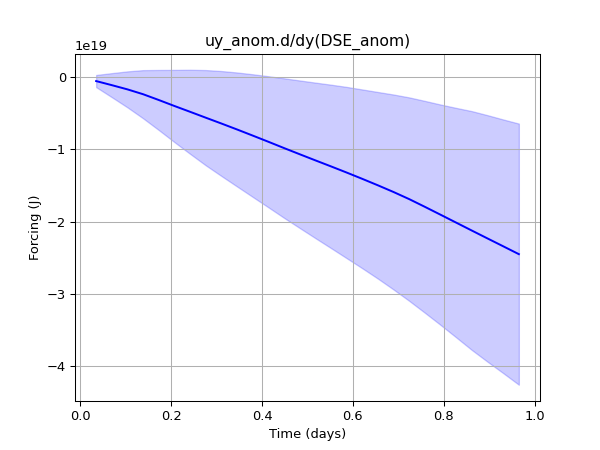

In [22]:
%matplotlib notebook
import seaborn as sns
import scipy.stats
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexk', 'rb') as f:
    heat_index= pickle.load(f)
    
with gzip.open('/home/scratch/Abel_data/rey_datk', 'rb') as f:
    convfh,convfh1,convfh2,convfv=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_priorik', 'rb') as f:
    prio=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_startk', 'rb') as f:
    st=pickle.load(f)

# p_std = np.arange(0.5, 9.6 ,0.5)[::-1]*10000
p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*100
print(p_std[12])
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

int_list=[]
dur_list=[]
a_list=[]
ac_list=[]

for i in range(len(convfh)):
    
    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])
    ## 0-DSEymean.windyanom 1-DSExamon.windxanom 2-DSExanom.windxmean v-DSEyanom.windyanom
    a=convfv[i][:,:7].sum(axis=1)
#     ah=convfh2[i][:,:7].sum(axis=1)+convfv[i][:,:7].sum(axis=1)

    ac=np.insert(a.cumsum(),0,0)
    a_list.append(a)
    ac_list.append(ac)
    
cut=np.quantile(dur_list,[0,0.1,0.45,0.55,0.9,1])

xx=[]
yy=[]
for i in range(len(int_list)):
    if (dur_list[i]>=cut[4]  and dur_list[i]<=cut[5]):
        
        xx.append(np.linspace(0,1,len(ac_list[i])))
        yy.append(ac_list[i])
        
#         plt.plot(np.linspace(0,1,len(ac_list[i])),ac_list[i])

xx_arr=np.linspace(0,1,30)
val_arr=[]
mean_arr=[];std_arr=[];x_arr=[]

for e in xx_arr:
    for i in range(len(xx)):
        if len(xx[i])>1:
            f = interpolate.interp1d(xx[i], yy[i])
            if e>xx[i][0] and xx[i][-1]>e:
                val_arr.append(f(e))
        
    if len(val_arr)>0:
        x_arr.append(e)
        mean_arr.append(np.mean(val_arr))
        std_arr.append(np.std(val_arr))
    val_arr=[]

x_arr=np.array(x_arr);mean_arr=np.array(mean_arr);std_arr=np.array(std_arr)
plt.plot(x_arr,mean_arr, color='blue')
plt.fill_between(x_arr, mean_arr-std_arr,mean_arr+std_arr, alpha=0.2,color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Forcing (J)')
plt.title('uy_anom.d/dy(DSE_anom)')
plt.grid()

730.0000000000001


<IPython.core.display.Javascript object>


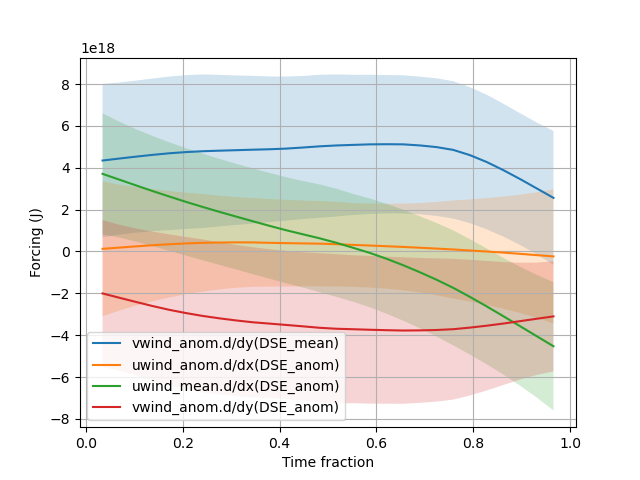

In [21]:
%matplotlib notebook
import seaborn as sns
import scipy.stats
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'rb') as f:
    heat_index= pickle.load(f)
    
with gzip.open('/home/scratch/Abel_data/rey_datv4', 'rb') as f:
    Rey=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_prioriv4', 'rb') as f:
    prio=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_startv4', 'rb') as f:
    st=pickle.load(f)

# p_std = np.arange(0.5, 9.6 ,0.5)[::-1]*10000
p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*100
print(p_std[12])
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

labels=['vwind_anom.d/dy(DSE_mean)','uwind_anom.d/dx(DSE_anom)','uwind_mean.d/dx(DSE_anom)','vwind_anom.d/dy(DSE_anom)']
for rey in range(len(Rey)):
    
    int_list=[]
    dur_list=[]
    a_list=[]
    ac_list=[]

    for i in range(len(Rey[rey])):

        int_list.append(heat_index[i][3])
        dur_list.append(heat_index[i][4])
        ## 0-DSEymean.windyanom 1-DSExamon.windxanom 2-DSExanom.windxmean v-DSEyanom.windyanom
        a=Rey[rey][i][:,:7].sum(axis=1)
        ac=a
    #     ah=convfh2[i][:,:7].sum(axis=1)+convfv[i][:,:7].sum(axis=1)

#         ac=np.insert(a.cumsum(),0,0)
        a_list.append(a)
        ac_list.append(ac)

    cut=np.quantile(dur_list,[0,0.1,0.45,0.55,0.9,1])

    xx=[]
    yy=[]
    for i in range(len(int_list)):
        if (dur_list[i]>=cut[0]  and dur_list[i]<=cut[5]):

            xx.append(np.linspace(0,1,len(ac_list[i])))
            yy.append(ac_list[i])

    #         plt.plot(np.linspace(0,1,len(ac_list[i])),ac_list[i])

    xx_arr=np.linspace(0,1,30)
    val_arr=[]
    mean_arr=[];std_arr=[];x_arr=[]

    for e in xx_arr:
        for i in range(len(xx)):
            if len(xx[i])>1:
                f = interpolate.interp1d(xx[i], yy[i])
                if e>xx[i][0] and xx[i][-1]>e:
                    val_arr.append(f(e))

        if len(val_arr)>0:
            x_arr.append(e)
            mean_arr.append(np.mean(val_arr))
            std_arr.append(np.std(val_arr))
        val_arr=[]

    x_arr=np.array(x_arr);mean_arr=np.array(mean_arr);std_arr=np.array(std_arr)
    plt.plot(x_arr,mean_arr,label=labels[rey])
    plt.fill_between(x_arr, mean_arr-std_arr,mean_arr+std_arr, alpha=0.2)
plt.xlabel('Time fraction')
plt.ylabel('Forcing (J)')
# plt.title('Low duration')
plt.grid()
plt.legend()

In [ ]:
%matplotlib notebook
import seaborn as sns
import scipy.stats
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexk', 'rb') as f:
    heat_index= pickle.load(f)
    
with gzip.open('/home/scratch/Abel_data/rey_datk', 'rb') as f:
    convfh,convfh1,convfh2,convfv=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_priorik', 'rb') as f:
    prio=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_startk', 'rb') as f:
    st=pickle.load(f)

# p_std = np.arange(0.5, 9.6 ,0.5)[::-1]*10000
p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*100
print(p_std[12])
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

int_list=[]
dur_list=[]
a_list=[]
ac_list=[]

for i in range(len(convfh)):
    
    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])
    ## 0-DSEymean.windyanom 1-DSExamon.windxanom 2-DSExanom.windxmean v-DSEyanom.windyanom
    a=convfv[i][:,:7].sum(axis=1)
#     ah=convfh2[i][:,:7].sum(axis=1)+convfv[i][:,:7].sum(axis=1)

    ac=np.insert(a.cumsum(),0,0)
    a_list.append(a)
    ac_list.append(ac)
    
cut=np.quantile(dur_list,[0,0.1,0.45,0.55,0.9,1])

xx=[]
yy=[]
for i in range(len(int_list)):
    if (dur_list[i]>=cut[4]  and dur_list[i]<=cut[5]):
        
        xx.append(np.linspace(0,1,len(ac_list[i])))
        yy.append(ac_list[i])
        
#         plt.plot(np.linspace(0,1,len(ac_list[i])),ac_list[i])

xx_arr=np.linspace(0,1,30)
val_arr=[]
mean_arr=[];std_arr=[];x_arr=[]

for e in xx_arr:
    for i in range(len(xx)):
        if len(xx[i])>1:
            f = interpolate.interp1d(xx[i], yy[i])
            if e>xx[i][0] and xx[i][-1]>e:
                val_arr.append(f(e))
        
    if len(val_arr)>0:
        x_arr.append(e)
        mean_arr.append(np.mean(val_arr))
        std_arr.append(np.std(val_arr))
    val_arr=[]

x_arr=np.array(x_arr);mean_arr=np.array(mean_arr);std_arr=np.array(std_arr)
plt.plot(x_arr,mean_arr, color='blue')
plt.fill_between(x_arr, mean_arr-std_arr,mean_arr+std_arr, alpha=0.2,color='blue')
plt.xlabel('Time (days)')
plt.ylabel('Forcing (J)')
plt.title('uy_anom.d/dy(DSE_anom)')
plt.grid()

1347


/tmp/ipykernel_774246/161123351.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  conv=np.array(convh)+np.array(convv)


0.8952561264516106 0.15980093045318702


<IPython.core.display.Javascript object>


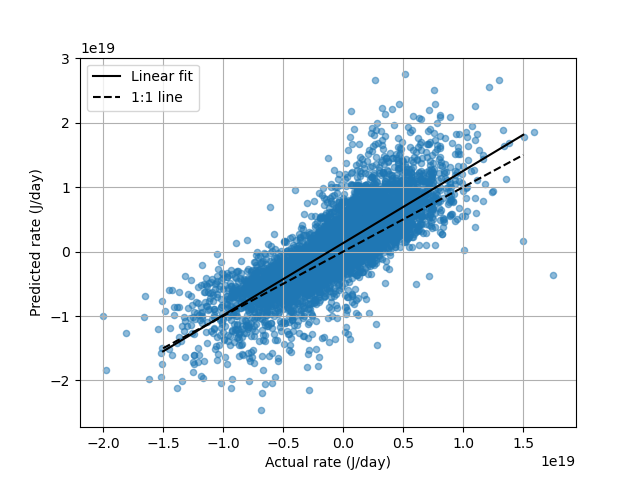

0.7993566507238666
LinregressResult(slope=1.1202247484771655, intercept=1.3230613636517996e+18, rvalue=0.7993566507238667, pvalue=0.0, stderr=0.009817812216854524, intercept_stderr=3.865768813685102e+16)
R2 0.7390487095660632 0.8398739382575514


Text(0, 0.5, 'Predicted rate (J/day)')

In [22]:
%matplotlib notebook
import seaborn as sns
import scipy.stats
from scipy import interpolate

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'rb') as f:
    heat_index= pickle.load(f)
    
with gzip.open('/home/scratch/Abel_data/Conv_datv4', 'rb') as f:
    convh,convv=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_prioriv4', 'rb') as f:
    prio=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_startv4', 'rb') as f:
    st=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/rey_datv4', 'rb') as f:
    Rey=pickle.load(f)

xx=[]
yy=[]
y0=[]
y1=[]
y2=[]
y3=[]
yref=[]
corr=[]
j=7
print(len(convh))
## 0-DSEymean.windyanom 1-DSExamon.windxanom 2-DSExanom.windxmean v-DSEyanom.windyanom
for i in range(len(convh)):

    # p_std = np.arange(0.5, 9.6 ,0.5)[::-1]*10000
    p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*100
#     print(p_std[7])

    # plt.plot(prio[i][:,:j].sum(axis=1))

#     conv=convh+convv
    # plt.plot(st[i][:j].sum()+np.insert(conv[i][:,:j].sum(axis=1),0,0).cumsum())
    
    first=prio[i][1:,:j].sum(axis=1)-prio[i][:-1,:j].sum(axis=1)
#     plt.plot(first, label='Actual')
    xx=xx+first.tolist()

#     conv=np.array(convh)
    conv=np.array(convh)+np.array(convv)
    secondref=(Rey[0][i][:,:j]+Rey[1][i][:,:j]+Rey[2][i][:,:j]+Rey[3][i][:,:j]).sum(axis=1)
#     second=(Rey[0][i][:,:j]+Rey[1][i][:,:j]+Rey[2][i][:,:j]+Rey[3][i][:,:j]).sum(axis=1)
    second=(Rey[0][i][:,:j]+Rey[2][i][:,:j]+Rey[3][i][:,:j]).sum(axis=1)
    s0=Rey[0][i][:,:j].sum(axis=1)
    s1=Rey[1][i][:,:j].sum(axis=1)
    s2=Rey[2][i][:,:j].sum(axis=1)
    s3=Rey[3][i][:,:j].sum(axis=1)
    yy=yy+second.tolist()
    y0=y0+s0.tolist()
    y1=y1+s1.tolist()
    y2=y2+s2.tolist()
    y3=y3+s3.tolist()
    yref=yref+secondref.tolist()
#     plt.plot(second, label='Calculated from advection')
    corr.append(scipy.stats.pearsonr(first,second)[0])
#     plt.legend()
#     plt.xlabel('Time (days)')
#     plt.ylabel('DSE difference (J)')
#     plt.show()

print(np.mean(corr), np.std(corr))
# plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('DSE difference (J)')

print(scipy.stats.pearsonr(xx,yy)[0])
plt.scatter(xx,yy,s=20,alpha=0.5)
plt.grid()
print(scipy.stats.linregress(xx,yy))
m=scipy.stats.linregress(xx,yy)[0]
x=scipy.stats.linregress(xx,yy)[1]

from sklearn.metrics import r2_score 
R_square = r2_score(yy, yref)
print('R2', R_square, scipy.stats.linregress(xx,yref)[2]**2)
# print(np.mean(np.array(yy)/np.array(yref)))

xarr=np.linspace(-1.5e19,1.5e19,100)
yarr=xarr*m+x
plt.plot(xarr,yarr,color='black', label='Linear fit')
plt.plot(xarr,xarr,color='black', label='1:1 line', linestyle='dashed')
plt.legend()
plt.xlabel('Actual rate (J/day)')
plt.ylabel('Predicted rate (J/day)')
# plt.title('DSE convergence comparison')
# print(np.mean(np.array(yy)-np.array(xx)))
# print(np.mean(yy))
# plt.savefig('/home/data/lab_abel/Paper1_var1/DSE_forcing1.pdf', bbox_inches='tight',dpi=900)

In [24]:
# %matplotlib notebook
from sympl import get_constant
from scipy import interpolate

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

Lv=2260000

lat1=11
lat2=17
lon1=35
lon2=41

common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*10000

def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

with gzip.open('/home/scratch/Abel_data/advection_meanv4', 'rb') as f:
    DSExmean, DSEymean, DSEzmean, windxmean, windymean, windzmean= pickle.load(f)

W=np.cos(lat_rad[1:-1,1:-1])*np.ones((len(p_std),4,4))
DSExmean=np.average(DSExmean, axis=(1,2), weights=W)
DSEymean=np.average(DSEymean, axis=(1,2), weights=W)
DSEzmean=np.average(DSEzmean, axis=(1,2), weights=W)
windxmean=np.average(windxmean, axis=(1,2), weights=W)
windymean=np.average(windymean, axis=(1,2), weights=W)
windzmean=np.average(windzmean, axis=(1,2), weights=W)

WXa=[]
WYa=[]
WZa=[]
DXa=[]
DYa=[]
DZa=[]

windx=[]
windy=[]
windz=[]
DSEx=[]
DSEy=[]
DSEz=[]

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'rb') as f:
    heat_index= pickle.load(f)
    
def interpol_time(X):
    
    t,h=np.shape(X)
    t_arr=np.linspace(0,1,t)
    t_std=np.array([0, 0.25, 0.5, 0.75, 1])
    out=np.zeros((5,h))
    
    for i in range(h):
        f = interpolate.interp1d(t_arr, X[:,i])
        out[:,i]=f(t_std)
            
    return out

test=0

for e in heat_index:
    
#     if test==20:
#         break
        
    test=test+1
    
    print(test)

    i=e[0]
    j=int(e[1])
    t_list=e[2]
    ignore=0

    for t in t_list:
        
#         t=t_0+k
        D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
        temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
        latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

        if np.min(press.values[0])<97000:
#             ignore=1
            print(np.min(press.values[0]))
            continue

        uwind=interpol1d(uwind, press)
        nwind=interpol1d(nwind, press)
        temp=interpol1d(temp, press)

        rho=(p_std[:,np.newaxis,np.newaxis]/(Rd*temp))[:,1:-1,1:-1]

        press_int=np.insert(p_std, 0, 101300)       

        # dz calculation

        dp=(press_int[:-1]-press_int[1:])

        dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
        z=dz.cumsum(axis=0)

        dse=Cp*temp+g*z

        dudx=(uwind[:,1:-1,2:]-uwind[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))
        dvdy=(nwind[:,2:,1:-1]*np.cos(lat_rad[2:,1:-1])-nwind[:,:-2,1:-1]*np.cos(lat_rad[:-2,1:-1]))/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*6371*1000*np.cos(lat_rad[1:-1,1:-1]))

        dwdp=-(dudx+dvdy)
        w=np.cumsum(dwdp*-dp[:,np.newaxis,np.newaxis],axis=0)

        windx.append(np.average(uwind[:,1:-1,1:-1],axis=(1,2), weights=W))
        DSEx.append(np.average(((dse[:,1:-1,2:]-dse[:,1:-1,:-2])/((lon_rad[1:-1,2:]-lon_rad[1:-1,:-2])*6371*1000*
                                                                  np.cos(lat_rad[1:-1,1:-1]))), axis=(1,2), weights=W))
        windy.append(np.average(nwind[:,1:-1,1:-1], axis=(1,2), weights=W))
        DSEy.append(np.average(((dse[:,2:,1:-1]-dse[:,:-2,1:-1])/((lat_rad[2:,1:-1]-lat_rad[:-2,1:-1])*
                                                                  6371*1000)),axis=(1,2), weights=W))

        
        windz.append(np.average(w, axis=(1,2), weights=W))
        dsez=uwind[:,1:-1,1:-1].copy()
        dsez[1:]=(dse[1:,1:-1,1:-1]-dse[:-1,1:-1,1:-1])/(-dp[1:,np.newaxis,np.newaxis])
        dsez[0]=(dse[1,1:-1,1:-1]-dse[0,1:-1,1:-1])/(-dp[1])
        DSEz.append(np.average(dsez, axis=(1,2), weights=W))

    
    if ignore==0:
        windxanom=np.array(windx)-windxmean
        windyanom=np.array(windy)-windymean
        windzanom=np.array(windz)-windzmean
        DSExanom=np.array(DSEx)-DSExmean
        DSEyanom=np.array(DSEy)-DSEymean
        DSEzanom=np.array(DSEz)-DSEzmean

        WXa.append(interpol_time(windxanom))
        WYa.append(interpol_time(windyanom))
        WZa.append(interpol_time(windzanom))
        DXa.append(interpol_time(DSExanom))
        DYa.append(interpol_time(DSEyanom))
        DZa.append(interpol_time(DSEzanom))
        
    windx=[]
    windy=[]
    windz=[]
    DSEx=[]
    DSEy=[]
    DSEz=[]
    
WXa=np.array(WXa)
WYa=np.array(WYa)
WZa=np.array(WZa)
DXa=np.array(DXa)
DYa=np.array(DYa)
DZa=np.array(DZa)


with gzip.open('/home/scratch/Abel_data/profilesv4', 'wb') as f:
    pickle.dump([WXa, WYa, WZa, DXa, DYa, DZa, windxmean, windymean, windzmean, DSExmean, DSEymean, DSEzmean], f)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


<IPython.core.display.Javascript object>


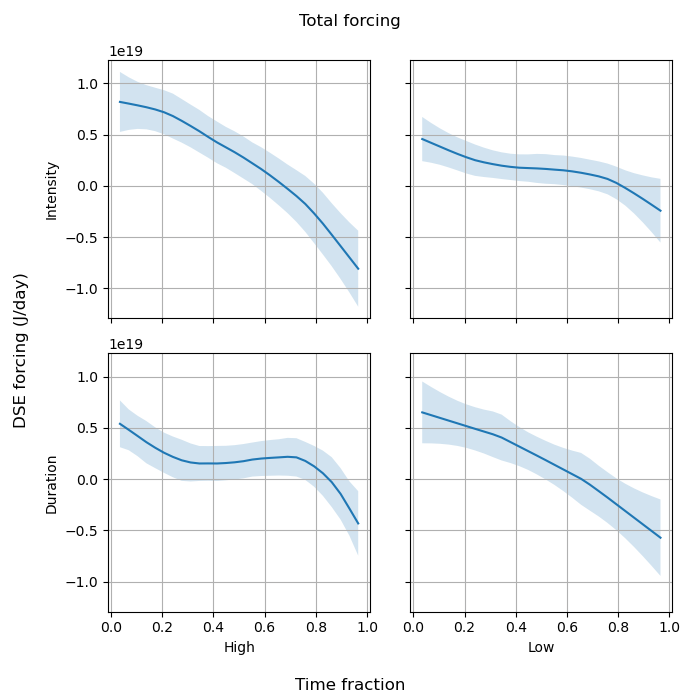

730.0000000000001


In [5]:
%matplotlib notebook
import seaborn as sns
import scipy.stats
from scipy import interpolate

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(7, 7)

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'rb') as f:
    heat_index= pickle.load(f)
    
with gzip.open('/home/scratch/Abel_data/rey_datv4', 'rb') as f:
    Rey=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_prioriv4', 'rb') as f:
    prio=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_startv4', 'rb') as f:
    st=pickle.load(f)

# p_std = np.arange(0.5, 9.6 ,0.5)[::-1]*10000
p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*100
print(p_std[12])
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out


int_list=[]
dur_list=[]
ac_list=[]

for i in range(len(Rey[0])):

    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])
    ## 0-DSEymean.windyanom 1-DSExamon.windxanom 2-DSExanom.windxmean v-DSEyanom.windyanom
    ac=Rey[0][i][:,:7].sum(axis=1)+Rey[1][i][:,:7].sum(axis=1)+Rey[2][i][:,:7].sum(axis=1)+Rey[3][i][:,:7].sum(axis=1)
#     ac=Rey[0][i][:,:7].sum(axis=1)+Rey[3][i][:,:7].sum(axis=1)
#     ac=Rey[1][i][:,:7].sum(axis=1)
    
    ac_list.append(ac)
    
cut=np.quantile(int_list,[0,0.1,0.45,0.55,0.9,1])

xx=[]
yy=[]
yy1=[]
for i in range(len(int_list)):
    if (int_list[i]>=cut[4]  and int_list[i]<=cut[5]):

        xx.append(np.linspace(0,1,len(ac_list[i])))
        yy.append(ac_list[i])

xx_arr=np.linspace(0,1,30)
val_arr=[]
mean_arr=[];std_arr=[];x_arr=[]

for e in xx_arr:
    for i in range(len(xx)):
        if len(xx[i])>1:
            f = interpolate.interp1d(xx[i], yy[i])
            if e>xx[i][0] and xx[i][-1]>e:
                val_arr.append(f(e))

    if len(val_arr)>0:
        x_arr.append(e)
        mean_arr.append(np.mean(val_arr))
        std_arr.append(np.std(val_arr))
    val_arr=[]

x_arr=np.array(x_arr);mean_arr=np.array(mean_arr);std_arr=np.array(std_arr)
ax[0][0].plot(x_arr,mean_arr)
ax[0][0].fill_between(x_arr, mean_arr-std_arr,mean_arr+std_arr, alpha=0.2)
ax[0][0].set_ylabel('Intensity')
ax[0][0].grid()

################################################################################################

cut=np.quantile(int_list,[0,0.1,0.45,0.55,0.9,1])

xx=[]
yy=[]
yy1=[]
for i in range(len(int_list)):
    if (int_list[i]>=cut[0]  and int_list[i]<=cut[1]):

        xx.append(np.linspace(0,1,len(ac_list[i])))
        yy.append(ac_list[i])

xx_arr=np.linspace(0,1,30)
val_arr=[]
mean_arr=[];std_arr=[];x_arr=[]

for e in xx_arr:
    for i in range(len(xx)):
        if len(xx[i])>1:
            f = interpolate.interp1d(xx[i], yy[i])
            if e>xx[i][0] and xx[i][-1]>e:
                val_arr.append(f(e))

    if len(val_arr)>0:
        x_arr.append(e)
        mean_arr.append(np.mean(val_arr))
        std_arr.append(np.std(val_arr))
    val_arr=[]

x_arr=np.array(x_arr);mean_arr=np.array(mean_arr);std_arr=np.array(std_arr)
ax[0][1].plot(x_arr,mean_arr)
ax[0][1].fill_between(x_arr, mean_arr-std_arr,mean_arr+std_arr, alpha=0.2)
ax[0][1].grid()

################################################################################################

cut=np.quantile(dur_list,[0,0.1,0.45,0.55,0.9,1])

xx=[]
yy=[]
yy1=[]
for i in range(len(int_list)):
    if (dur_list[i]>=cut[4]  and dur_list[i]<=cut[5]):

        xx.append(np.linspace(0,1,len(ac_list[i])))
        yy.append(ac_list[i])

xx_arr=np.linspace(0,1,30)
val_arr=[]
mean_arr=[];std_arr=[];x_arr=[]

for e in xx_arr:
    for i in range(len(xx)):
        if len(xx[i])>1:
            f = interpolate.interp1d(xx[i], yy[i])
            if e>xx[i][0] and xx[i][-1]>e:
                val_arr.append(f(e))

    if len(val_arr)>0:
        x_arr.append(e)
        mean_arr.append(np.mean(val_arr))
        std_arr.append(np.std(val_arr))
    val_arr=[]

x_arr=np.array(x_arr);mean_arr=np.array(mean_arr);std_arr=np.array(std_arr)
ax[1][0].plot(x_arr,mean_arr)
ax[1][0].fill_between(x_arr, mean_arr-std_arr,mean_arr+std_arr, alpha=0.2)
ax[1][0].set_xlabel('High')
ax[1][0].set_ylabel('Duration')
ax[1][0].grid()

#################################################################################################

cut=np.quantile(dur_list,[0,0.1,0.45,0.55,0.9,1])

xx=[]
yy=[]
yy1=[]
for i in range(len(int_list)):
    if (dur_list[i]>=cut[0]  and dur_list[i]<=cut[1]):

        xx.append(np.linspace(0,1,len(ac_list[i])))
        yy.append(ac_list[i])

xx_arr=np.linspace(0,1,30)
val_arr=[]
mean_arr=[];std_arr=[];x_arr=[]

for e in xx_arr:
    for i in range(len(xx)):
        if len(xx[i])>1:
            f = interpolate.interp1d(xx[i], yy[i])
            if e>xx[i][0] and xx[i][-1]>e:
                val_arr.append(f(e))

    if len(val_arr)>0:
        x_arr.append(e)
        mean_arr.append(np.mean(val_arr))
        std_arr.append(np.std(val_arr))
    val_arr=[]

x_arr=np.array(x_arr);mean_arr=np.array(mean_arr);std_arr=np.array(std_arr)
ax[1][1].plot(x_arr,mean_arr)
ax[1][1].fill_between(x_arr, mean_arr-std_arr,mean_arr+std_arr, alpha=0.2)
ax[1][1].set_xlabel('Low')
ax[1][1].grid()

fig.supxlabel('Time fraction')
fig.supylabel('DSE forcing (J/day)')
# fig.suptitle('v_anom component')
fig.suptitle('Total forcing')
plt.tight_layout()
# plt.legend()
# plt.savefig('/home/data/lab_abel/Paper1_var1/Reynolds1.pdf', bbox_inches='tight',dpi=900)

<IPython.core.display.Javascript object>


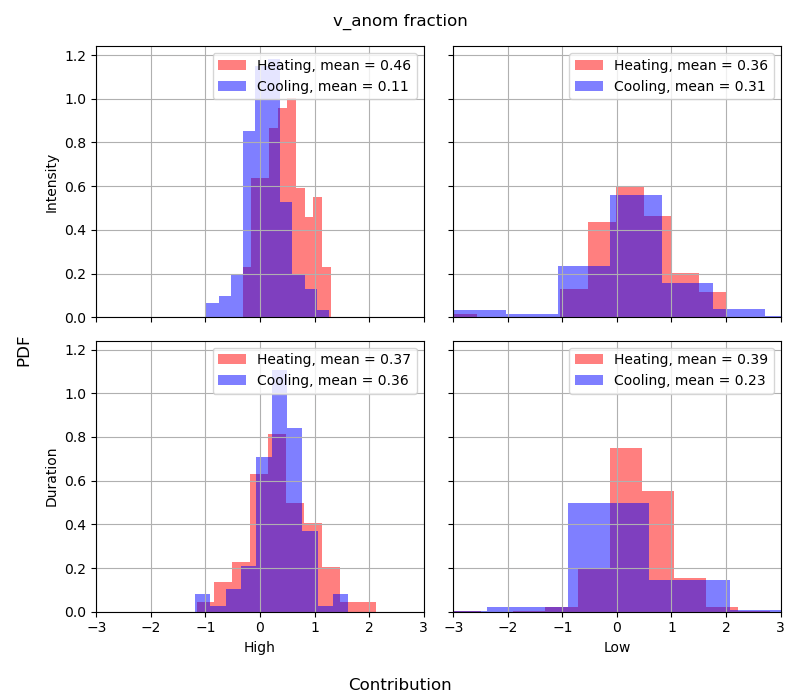

730.0000000000001


In [5]:
%matplotlib notebook
import seaborn as sns
import scipy.stats
from scipy import interpolate

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(8, 7)

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'rb') as f:
    heat_index= pickle.load(f)
    
with gzip.open('/home/scratch/Abel_data/rey_datv4', 'rb') as f:
    Rey=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_prioriv4', 'rb') as f:
    prio=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_startv4', 'rb') as f:
    st=pickle.load(f)

# p_std = np.arange(0.5, 9.6 ,0.5)[::-1]*10000
p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*100
print(p_std[12])
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

dot_h=[]
dot_c=[]
int_list=[]
dur_list=[]

for i in range(len(Rey[0])):
    
    ac_tot=Rey[0][i][:,:7].sum(axis=1)+Rey[1][i][:,:7].sum(axis=1)+Rey[2][i][:,:7].sum(axis=1)+Rey[3][i][:,:7].sum(axis=1)
    ac=(Rey[0][i][:,:7].sum(axis=1)+Rey[3][i][:,:7].sum(axis=1))
#     ac=Rey[1][i][:,:7].sum(axis=1)

    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])

    ## 0-DSEymean.windyanom 1-DSExamon.windxanom 2-DSExanom.windxmean v-DSEyanom.windyanom

    cent=int(len(ac_tot)/2)

#     print(ac_tot[:cent+1], ac_tot[cent:])

    dot_h.append(np.dot(ac_tot[:cent+1], ac[:cent+1])/np.dot(ac_tot[:cent+1],ac_tot[:cent+1]))
    dot_c.append(np.dot(ac_tot[cent:], ac[cent:])/np.dot(ac_tot[cent:],ac_tot[cent:]))
    
cut=np.quantile(int_list,[0,0.1,0.45,0.55,0.9,1])

dothsel=[]
dotcsel=[]
for i in range(len(int_list)):
    if (int_list[i]>=cut[4]  and int_list[i]<=cut[5]):

        dothsel.append(dot_h[i])
        dotcsel.append(dot_c[i])

ax[0][0].hist(dothsel, color='red', density=True, alpha=0.5, label='Heating, mean = ' +str('{0:.2f}'.format(np.mean(dothsel))))
ax[0][0].hist(dotcsel, color='blue', density=True, alpha=0.5, label='Cooling, mean = ' +str('{0:.2f}'.format(np.mean(dotcsel))))
ax[0][0].set_ylabel('Intensity')
ax[0][0].legend()
ax[0][0].grid()

# ################################################################################################

cut=np.quantile(int_list,[0,0.1,0.45,0.55,0.9,1])

dothsel=[]
dotcsel=[]
for i in range(len(int_list)):
    if (int_list[i]>=cut[0]  and int_list[i]<=cut[1]):

        dothsel.append(dot_h[i])
        dotcsel.append(dot_c[i])

ax[0][1].hist(dothsel, color='red', density=True, alpha=0.5, label='Heating, mean = ' +str('{0:.2f}'.format(np.mean(dothsel))))
ax[0][1].hist(dotcsel, color='blue', density=True, alpha=0.5, label='Cooling, mean = ' +str('{0:.2f}'.format(np.mean(dotcsel))))
ax[0][1].set_xlim([-3,3])
ax[0][1].legend()
ax[0][1].grid()

# ################################################################################################

cut=np.quantile(dur_list,[0,0.1,0.45,0.55,0.9,1])

dothsel=[]
dotcsel=[]
for i in range(len(int_list)):
    if (dur_list[i]>=cut[4]  and int_list[i]<=cut[5]):

        dothsel.append(dot_h[i])
        dotcsel.append(dot_c[i])

ax[1][0].hist(dothsel, color='red', density=True, alpha=0.5, label='Heating, mean = ' +str('{0:.2f}'.format(np.mean(dothsel))))
ax[1][0].hist(dotcsel, color='blue', density=True, alpha=0.5, label='Cooling, mean = ' +str('{0:.2f}'.format(np.mean(dotcsel))))
ax[1][0].set_xlim([-3,3])
ax[1][0].set_xlabel('High')
ax[1][0].set_ylabel('Duration')
ax[1][0].legend()
ax[1][0].grid()

# #################################################################################################

cut=np.quantile(dur_list,[0,0.1,0.45,0.55,0.9,1])

dothsel=[]
dotcsel=[]
for i in range(len(int_list)):
    if (dur_list[i]>=cut[0]  and int_list[i]<=cut[1]):

        dothsel.append(dot_h[i])
        dotcsel.append(dot_c[i])

ax[1][1].hist(dothsel, color='red', density=True, alpha=0.5, label='Heating, mean = ' +str('{0:.2f}'.format(np.mean(dothsel))))
ax[1][1].hist(dotcsel, color='blue', density=True, alpha=0.5, label='Cooling, mean = ' +str('{0:.2f}'.format(np.mean(dotcsel))))
ax[1][1].set_xlim([-3,3])
ax[1][1].set_xlabel('Low')
ax[1][1].legend()
ax[1][1].grid()

fig.supxlabel('Contribution')
fig.supylabel('PDF')
fig.suptitle('v_anom fraction')
plt.tight_layout()
# # plt.savefig('/home/data/lab_abel/Paper1_var1/Reynolds1.pdf', bbox_inches='tight',dpi=900)

<IPython.core.display.Javascript object>


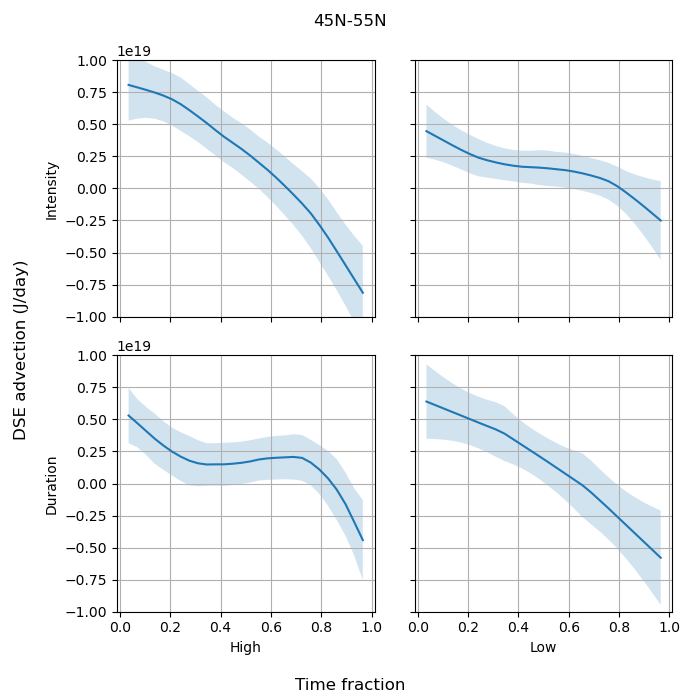

730.0000000000001


In [4]:
%matplotlib notebook
import seaborn as sns
import scipy.stats
from scipy import interpolate

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(7, 7)

with gzip.open('/home/scratch/Abel_data/heat_indexv4_cut', 'rb') as f:
    heat_index= pickle.load(f)
    
with gzip.open('/home/scratch/Abel_data/rey_datv4', 'rb') as f:
    Rey=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_prioriv4', 'rb') as f:
    prio=pickle.load(f)
with gzip.open('/home/scratch/Abel_data/Conv_startv4', 'rb') as f:
    st=pickle.load(f)
    
with gzip.open('/home/scratch/Abel_data/Conv_datv4', 'rb') as f:
    convh,convv=pickle.load(f)


# p_std = np.arange(0.5, 9.6 ,0.5)[::-1]*10000
p_std = np.arange(0.1, 9.9 ,0.2)[::-1]*100
print(p_std[12])
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out


int_list=[]
dur_list=[]
ac_list=[]

for i in range(len(Rey[0])):

    int_list.append(heat_index[i][3])
    dur_list.append(heat_index[i][4])
    ## 0-DSEymean.windyanom 1-DSExamon.windxanom 2-DSExanom.windxmean v-DSEyanom.windyanom
    ac_tot=convh[i][:,:7].sum(axis=1)+convv[i][:,:7].sum(axis=1)
#     ac_tot=convv[i][:,:7].sum(axis=1)+Rey[0][i][:,:7].sum(axis=1)+Rey[1][i][:,:7].sum(axis=1)+Rey[2][i][:,:7].sum(axis=1)+Rey[3][i][:,:7].sum(axis=1)
    
#     ac=(Rey[0][i][:,:7].sum(axis=1)+Rey[3][i][:,:7].sum(axis=1))/ac_tot
#     ac=(Rey[2][i][:,:7].sum(axis=1))
    
#     ac[ac>1]=1
#     ac[ac<0]=0
    
    ac_list.append(ac_tot)
    
cut=np.quantile(int_list,[0,0.1,0.45,0.55,0.9,1])

xx=[]
yy=[]
yy1=[]
for i in range(len(int_list)):
    if (int_list[i]>=cut[4]  and int_list[i]<=cut[5]):

        xx.append(np.linspace(0,1,len(ac_list[i])))
        yy.append(ac_list[i])

xx_arr=np.linspace(0,1,30)
val_arr=[]
mean_arr=[];std_arr=[];x_arr=[]

for e in xx_arr:
    for i in range(len(xx)):
        if len(xx[i])>1:
            f = interpolate.interp1d(xx[i], yy[i])
            if e>xx[i][0] and xx[i][-1]>e:
                val_arr.append(f(e))

    if len(val_arr)>0:
        x_arr.append(e)
        mean_arr.append(np.mean(val_arr))
        std_arr.append(np.std(val_arr))
    val_arr=[]

x_arr=np.array(x_arr);mean_arr=np.array(mean_arr);std_arr=np.array(std_arr)
ax[0][0].plot(x_arr,mean_arr)
ax[0][0].fill_between(x_arr, mean_arr-std_arr,mean_arr+std_arr, alpha=0.2)
ax[0][0].set_ylabel('Intensity')
ax[0][0].grid()

################################################################################################

cut=np.quantile(int_list,[0,0.1,0.45,0.55,0.9,1])

xx=[]
yy=[]
yy1=[]
for i in range(len(int_list)):
    if (int_list[i]>=cut[0]  and int_list[i]<=cut[1]):

        xx.append(np.linspace(0,1,len(ac_list[i])))
        yy.append(ac_list[i])

xx_arr=np.linspace(0,1,30)
val_arr=[]
mean_arr=[];std_arr=[];x_arr=[]

for e in xx_arr:
    for i in range(len(xx)):
        if len(xx[i])>1:
            f = interpolate.interp1d(xx[i], yy[i])
            if e>xx[i][0] and xx[i][-1]>e:
                val_arr.append(f(e))

    if len(val_arr)>0:
        x_arr.append(e)
        mean_arr.append(np.mean(val_arr))
        std_arr.append(np.std(val_arr))
    val_arr=[]

x_arr=np.array(x_arr);mean_arr=np.array(mean_arr);std_arr=np.array(std_arr)
ax[0][1].plot(x_arr,mean_arr)
ax[0][1].fill_between(x_arr, mean_arr-std_arr,mean_arr+std_arr, alpha=0.2)
ax[0][1].grid()

################################################################################################

cut=np.quantile(dur_list,[0,0.1,0.45,0.55,0.9,1])

xx=[]
yy=[]
yy1=[]
for i in range(len(int_list)):
    if (dur_list[i]>=cut[4]  and dur_list[i]<=cut[5]):

        xx.append(np.linspace(0,1,len(ac_list[i])))
        yy.append(ac_list[i])

xx_arr=np.linspace(0,1,30)
val_arr=[]
mean_arr=[];std_arr=[];x_arr=[]

for e in xx_arr:
    for i in range(len(xx)):
        if len(xx[i])>1:
            f = interpolate.interp1d(xx[i], yy[i])
            if e>xx[i][0] and xx[i][-1]>e:
                val_arr.append(f(e))

    if len(val_arr)>0:
        x_arr.append(e)
        mean_arr.append(np.mean(val_arr))
        std_arr.append(np.std(val_arr))
    val_arr=[]

x_arr=np.array(x_arr);mean_arr=np.array(mean_arr);std_arr=np.array(std_arr)
ax[1][0].plot(x_arr,mean_arr)
ax[1][0].fill_between(x_arr, mean_arr-std_arr,mean_arr+std_arr, alpha=0.2)
ax[1][0].set_xlabel('High')
ax[1][0].set_ylabel('Duration')
ax[1][0].grid()

#################################################################################################

cut=np.quantile(dur_list,[0,0.1,0.45,0.55,0.9,1])

xx=[]
yy=[]
yy1=[]
for i in range(len(int_list)):
    if (dur_list[i]>=cut[0]  and dur_list[i]<=cut[1]):

        xx.append(np.linspace(0,1,len(ac_list[i])))
        yy.append(ac_list[i])

xx_arr=np.linspace(0,1,30)
val_arr=[]
mean_arr=[];std_arr=[];x_arr=[]

for e in xx_arr:
    for i in range(len(xx)):
        if len(xx[i])>1:
            f = interpolate.interp1d(xx[i], yy[i])
            if e>xx[i][0] and xx[i][-1]>e:
                val_arr.append(f(e))

    if len(val_arr)>0:
        x_arr.append(e)
        mean_arr.append(np.mean(val_arr))
        std_arr.append(np.std(val_arr))
    val_arr=[]

x_arr=np.array(x_arr);mean_arr=np.array(mean_arr);std_arr=np.array(std_arr)
ax[1][1].plot(x_arr,mean_arr)
ax[1][1].fill_between(x_arr, mean_arr-std_arr,mean_arr+std_arr, alpha=0.2)
ax[1][1].set_xlabel('Low')
ax[1][1].set_ylim([-1e19, 1e19])
ax[1][1].grid()

fig.supxlabel('Time fraction')
fig.supylabel('DSE advection (J/day)')
fig.suptitle('45N-55N')
plt.tight_layout()
# plt.legend()
# plt.savefig('/home/data/lab_abel/Paper1_var1/Reynolds1.pdf', bbox_inches='tight',dpi=900)
plt.savefig('/home/data/lab_abel/Paper1_plots/fig6d_tot.pdf', bbox_inches='tight')